In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Preprocessed Time Series Final.csv')

In [4]:
df.head()

,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,category_code_3,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,1,1002532,2.053010e+18,0.937399,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,26204062,2.053010e+18,-0.188667,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,4804055,2.053010e+18,-0.342339,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,1307240,2.053010e+18,0.211381,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,1002524,2.053010e+18,0.578390,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
features = ['price'] + [f'category_code_{i}' for i in range(5)] + [f'brand_{i}' for i in range(12)]

In [6]:
 #Step 2: Prepare X and y
X = df[features].values  # shape (num_samples, num_features)
y = df['event_type'].values  # labels (strings)


In [7]:
from sklearn.preprocessing import LabelEncoder

# Step 3: Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # e.g. 'view' -> 0, 'cart' -> 1, 'purchase' -> 2

num_classes = len(le.classes_)

In [8]:
 #Step 4: Convert y to one-hot vectors
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

In [9]:
# Step 5: Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)


In [10]:
# Step 6: Prepare data for LSTM
# LSTM expects 3D input: (samples, timesteps, features)
# If your data isn't sequential, you can treat each sample as a sequence of length 1:
seq_length = 1
num_features = len(features)

X_train = X_train.reshape((X_train.shape[0], seq_length, num_features))
X_test = X_test.reshape((X_test.shape[0], seq_length, num_features))


In [11]:
# Step 7: Build the LSTM model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(seq_length, num_features)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - accuracy: 0.4508 - loss: 1.0369 - val_accuracy: 0.4694 - val_loss: 1.0144
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.4663 - loss: 1.0142 - val_accuracy: 0.4675 - val_loss: 1.0092
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - accuracy: 0.4709 - loss: 1.0075 - val_accuracy: 0.4712 - val_loss: 1.0046
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.4719 - loss: 1.0042 - val_accuracy: 0.4719 - val_loss: 1.0045
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.4736 - loss: 1.0021 - val_accuracy: 0.4741 - val_loss: 1.0012
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.4732 - loss: 1.0002 - val_accuracy: 0.4694 - val_loss: 1.0031
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step - accuracy: 0.4734 - loss: 0.9995 - val_accuracy: 0.4771 - val_loss: 0.9990
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 93s 5ms/step - accur

In [14]:
# Step 9: Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4740 - loss: 0.9980
Test Accuracy: 0.4741


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


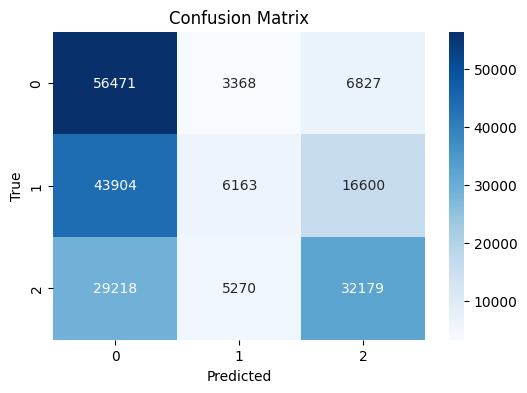

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Get predicted classes for test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#save the model
from tensorflow.keras.models import load_model
model.save('lstm_model.h5')

In [17]:
#load the model
loaded_model = load_model('lstm_model.h5')